In [1]:
import math
import sys
import itertools
from pathlib import Path
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import pickle

from tqdm import tqdm

# sys.path.append("/usr/tce/packages/nsight-compute/nsight-compute-2023.2.2/extras/python")

import hatchet as ht
import thicket as th

from IPython.display import HTML
import pygwalker as pyg, pygwalker_utils.config as pyg_conf

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
ncu_lassen = th.Thicket.from_pickle("ncu_data.pkl")

In [3]:
kernel_types =["RAJAPerf", "Algorithm", "Apps", "Basic", "Comm", "Lcals", "Polybench", "Stream"]

In [4]:
raja_kernel_query = (
    ht.QueryMatcher()
    .match (
        ".",
        lambda row: row["name"].apply(
            lambda x: any([x.startswith(c) for c in kernel_types[1:]])
        ).all()
    )
    .rel("*")
)

In [5]:
pruned_th = ncu_lassen.query(raja_kernel_query)

In [6]:
cols = pruned_th.dataframe.columns.tolist()[2:]

In [7]:
for i in ["name", "time (inc)", "time (gpu) (inc)"]:
    cols.remove(i)

In [8]:
#
q1 = """
MATCH (".",p)->("*")
WHERE p."name" = "{ker}"
"""

#
q2 = """
MATCH (".", p)
WHERE p."depth" = 2
"""

In [9]:
leaves = []

for n in pruned_th.graph.roots:
    kernels = {}
    
    kernels["name"] = n.frame.get("name")
    
    
    tmp = q1.format(ker=n.frame.get("name"))
    ker_th = pruned_th.query(tmp, multi_index_mode="all")
    leaf = ker_th.query(q2, multi_index_mode="all")
    for col in cols:
        kernels[col] = leaf.dataframe[col].sum()
    
    leaves.append(kernels)

agg_df = pd.DataFrame(data=leaves)

## Calculate Rooflines

### Instruction Intensity

#### Warp Instructions

In [10]:
agg_df["Warp Instructions"] = agg_df["sm__sass_thread_inst_executed.sum"] / 32

#### Count Memory Transactions

- L1 Global Count Memory Transactions

In [11]:
agg_df["L1 (GLOBAL)"] = agg_df["l1tex__t_sectors_pipe_lsu_mem_global_op_ld.sum"] + agg_df["l1tex__t_sectors_pipe_lsu_mem_global_op_st.sum"]
agg_df["L1 (SHARED)"] = agg_df["l1tex__data_pipe_lsu_wavefronts_mem_shared_op_ld.sum"] + agg_df["l1tex__data_pipe_lsu_wavefronts_mem_shared_op_st.sum"]
agg_df["Total L1 Transactions"] = agg_df["L1 (GLOBAL)"] + (4 * agg_df["L1 (SHARED)"])

- Shared Count Memory Transactions

In [12]:
agg_df["L2 Write Transactions"] =  agg_df["lts__t_sectors_op_write.sum"] + agg_df["lts__t_sectors_op_atom.sum"] + agg_df["lts__t_sectors_op_red.sum"]
agg_df["L2 Read Transactions"] =  agg_df["lts__t_sectors_op_read.sum"] + agg_df["lts__t_sectors_op_atom.sum"] + agg_df["lts__t_sectors_op_red.sum"]
agg_df["Total L2 Transactions"] = agg_df["L2 Read Transactions"] + agg_df["L2 Write Transactions"]

- HBM Count Memory Transactions

In [13]:
agg_df["HBM Transactions"] = agg_df["dram__sectors_read.sum"] +  agg_df["dram__sectors_write.sum"]

#### Intruction Intensities

In [14]:
agg_df["L1 Instruction Intensity"] = agg_df["Warp Instructions"] / agg_df["Total L1 Transactions"]

In [15]:
agg_df["L2 Instruction Intensity"] = agg_df["Warp Instructions"] / agg_df["Total L2 Transactions"]

In [16]:
agg_df["HBM Instruction Intensity"] = agg_df["Warp Instructions"] / agg_df["HBM Transactions"]

### Performance

In [17]:
agg_df["Performance GIPS"] = agg_df["Warp Instructions"] / (agg_df["time (gpu)"] * (10 ** 9))

## Plotting

In [18]:
get_raja_kernels = """
    MATCH (".", p)
    WHERE p."depth" = 2
"""

In [19]:
pruned_th_kers = ncu_lassen.query(get_raja_kernels, multi_index_mode="all")

In [20]:
metrics = ["L1 Instruction Intensity", "L2 Instruction Intensity", "HBM Instruction Intensity"]

In [21]:
c_s = ["red", "blue", "green", "orange", "purple", "cyan", "magenta"]
final_colors = []
for i in agg_df["name"].tolist():
    for j in range(1, len(kernel_types)):
        if i.startswith(kernel_types[j]):
            final_colors.append(c_s[j - 1])
            continue

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

font = { 'size'   : 15}
plt.rc('font', **font)

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

markersize = 10
markerwidth = 2
maxchar = 25

def roofline(LABELS, flag='HBM', data_df=None):
    LABELS = [x[:maxchar] for x in LABELS]
    
    bandiwdth_hbm = 25.9 # in GTXN/s
    bandwidth_l2 = 93.6 # in GTXN/s
    bandwidth_l1 = 437.5 # in GTXN/s
    
    if flag == "L1":
        memRoofs = [('L1', 437.5)]
    elif flag == "L2":
        memRoofs = [('L2', 93.6)]
    elif flag == "HBM":
        memRoofs = [('HBM', 25.9)]
    elif flag == "all":
        memRoofs = [('L1', 437.5), ('L2', 93.6),  ('HBM', 25.9)]

    cmpRoofs = [("GIPS", 489.6)]

    fig = plt.figure(1,figsize=(10.67,6.6))
    plt.clf()
    ax = fig.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Instruction Intensity [Warp Instructions/transaction]')
    ax.set_ylabel('Performance [Warp GIPS]')

    nx   = 10000
    xmin = -3 
    xmax = 3
    ymin = 1
    ymax = 1000

    ax.set_xlim(10**xmin, 10**xmax)
    ax.set_ylim(ymin, ymax)

    ixx = int(nx*0.02)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    scomp_x_elbow  = []
    scomp_ix_elbow = []
    smem_x_elbow   = []
    smem_ix_elbow  = []

    x = np.logspace(xmin,xmax,nx)
    for roof in cmpRoofs:
        for ix in range(1,nx):
            if float(memRoofs[0][1] * x[ix]) >= roof[1] and (memRoofs[0][1] * x[ix-1]) < roof[1]:
                scomp_x_elbow.append(x[ix-1])
                scomp_ix_elbow.append(ix-1)
                break

    for roof in memRoofs:
        for ix in range(1,nx):
            if (cmpRoofs[0][1] <= roof[1] * x[ix] and cmpRoofs[0][1] > roof[1] * x[ix-1]):
                smem_x_elbow.append(x[ix-1])
                smem_ix_elbow.append(ix-1)
                break

    for i in range(len(cmpRoofs)):
        roof = cmpRoofs[i][1]
        y = np.ones(len(x)) * roof
        ax.plot(x[scomp_ix_elbow[i]:],y[scomp_ix_elbow[i]:],c='k',ls='-',lw='2')

    for i in range(len(memRoofs)):
        roof = memRoofs[i][1]
        y = x * roof
        ax.plot(x[:smem_ix_elbow[i]+1],y[:smem_ix_elbow[i]+1],c='k',ls='-',lw='2')

        
    for roof in cmpRoofs:
        ax.text(x[-ixx],roof[1],
              roof[0] + ': ' + '{0:.1f}'.format(roof[1]) + ' Warp GIPS',
              horizontalalignment='right',
              verticalalignment='bottom')

    for roof in memRoofs:
        ang = np.arctan(np.log10(xlim[1]/xlim[0]) / np.log10(ylim[1]/ylim[0])
                                   * fig.get_size_inches()[1]/fig.get_size_inches()[0] )
        if x[ixx]*roof[1] > ymin:
            ax.text(x[ixx],x[ixx]*roof[1]*(1+0.25*np.sin(ang)**2),
              roof[0] + ': ' + '{0:.1f}'.format(float(roof[1])) + ' GTXN/s',
              horizontalalignment='left',
              verticalalignment='bottom',
              rotation=180/np.pi*ang)
        else:
            ymin_ix_elbow=list()
            ymin_x_elbow=list()
            for ix in range(1,nx):
                if (ymin <= roof[1] * x[ix] and ymin > roof[1] * x[ix-1]):
                    ymin_x_elbow.append(x[ix-1])
                    ymin_ix_elbow.append(ix-1)
                    break
            ax.text(x[ixx+ymin_ix_elbow[0]],x[ixx+ymin_ix_elbow[0]]*roof[1]*(1+0.25*np.sin(ang)**2) * 1.15,
              roof[0] + ': ' + '{0:.1f}'.format(float(roof[1])) + ' GTXN/s',
              horizontalalignment='left',
              verticalalignment='bottom',
              rotation=180/np.pi*ang)

    if flag == "L1":
        ax.scatter(data_df[metrics[0]], data_df["Performance GIPS"], c=final_colors, label="L1", marker=styles[0])
    elif flag == "L2":
        ax.scatter(data_df[metrics[1]], data_df["Performance GIPS"], c=final_colors, label="L2", marker=styles[1])
    elif flag == "HBM":
        ax.scatter(data_df[metrics[2]], data_df["Performance GIPS"], c=final_colors, label="HBM", marker="*")

    elif flag == "all":
        ax.scatter(data_df[metrics[0]], data_df["Performance GIPS"], c=final_colors, label="L1", marker=styles[0])
        ax.scatter(data_df[metrics[1]], data_df["Performance GIPS"], c=final_colors, label="L2", marker=styles[1])
        ax.scatter(data_df[metrics[2]], data_df["Performance GIPS"], c=final_colors, label="HBM", marker="*")

    custom_labels = kernel_types[1:]
    custom_handles = [plt.Line2D([0], [0], color=i, lw=2) for i in c_s]
    
    if flag == "HBM":
        leg2 = ax.legend(custom_handles, custom_labels,
                         bbox_to_anchor=(0.36, 1),
                         title="Kernel Types",
                         fontsize='12',          # Adjust label font size (e.g., 'small', 'medium', 'large', or specific size)
                         title_fontsize='small')
    else:
        leg2 = ax.legend(custom_handles, custom_labels,
                         bbox_to_anchor=(0.36, 0.59),
                         title="Kernel Types",
                         fontsize='12',          # Adjust label font size (e.g., 'small', 'medium', 'large', or specific size)
                         title_fontsize='small')
        
    ax.add_artist(leg2)
    
    ax.legend(loc='upper left')
    plt.show()

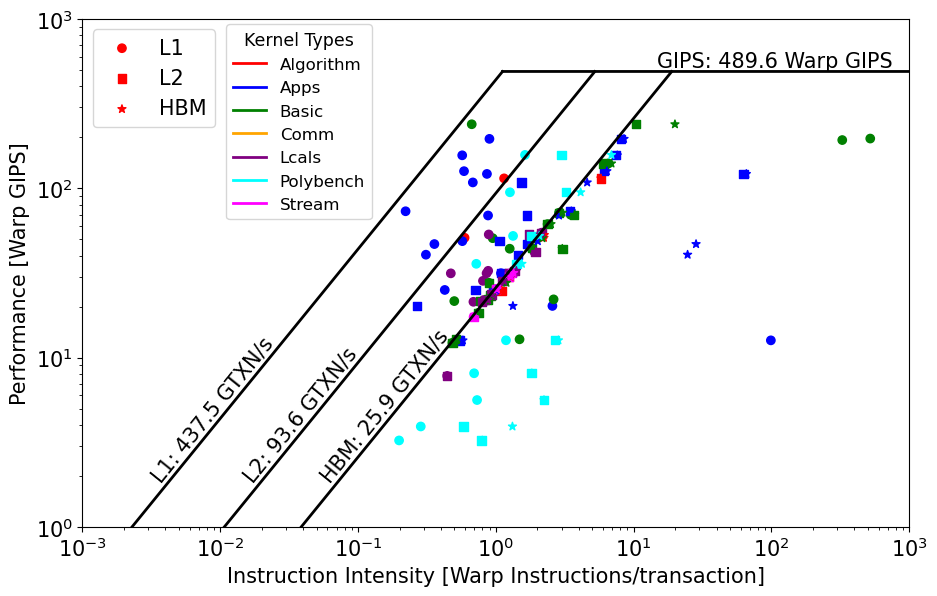

In [23]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag='all', data_df=agg_df)

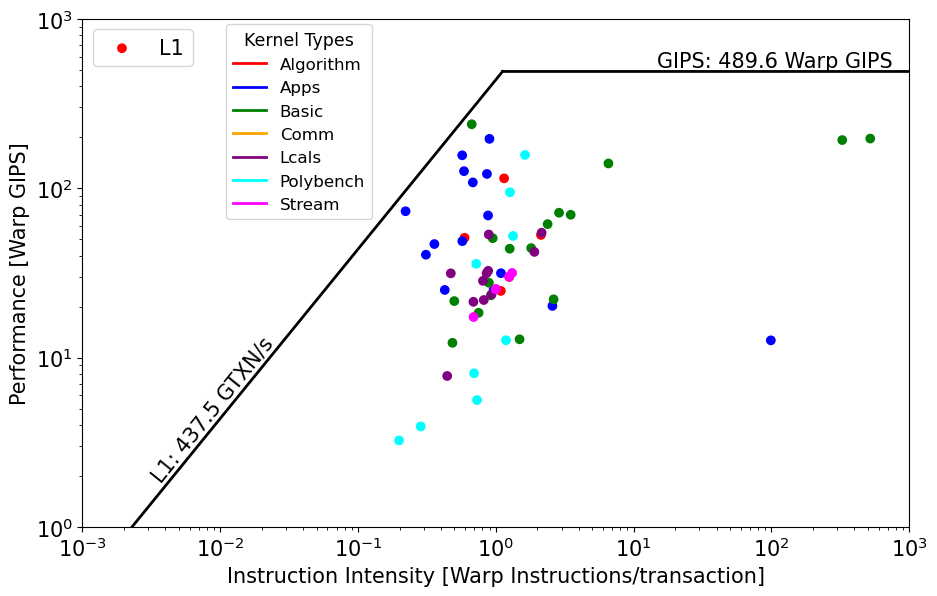

In [24]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag='L1', data_df=agg_df)

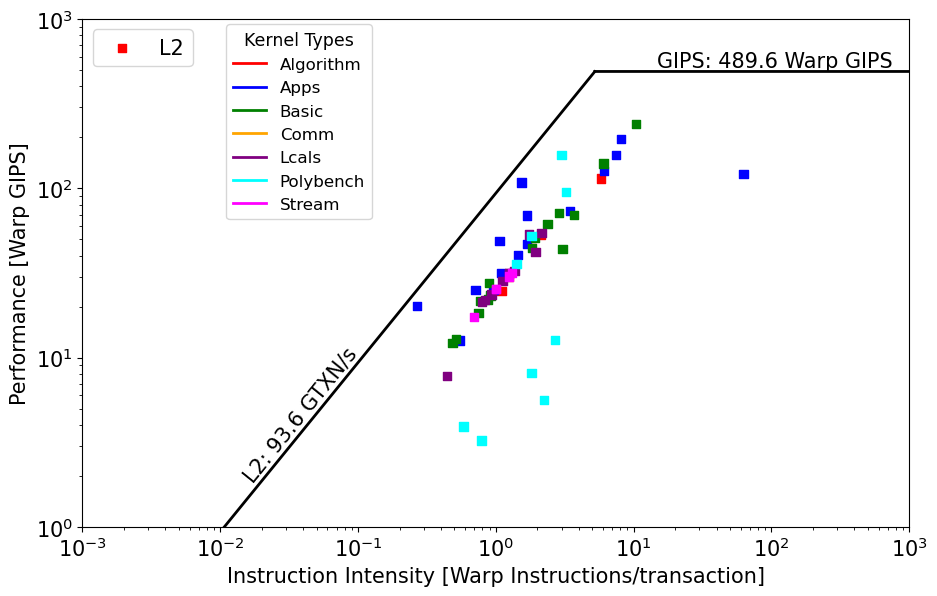

In [25]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag='L2', data_df=agg_df)

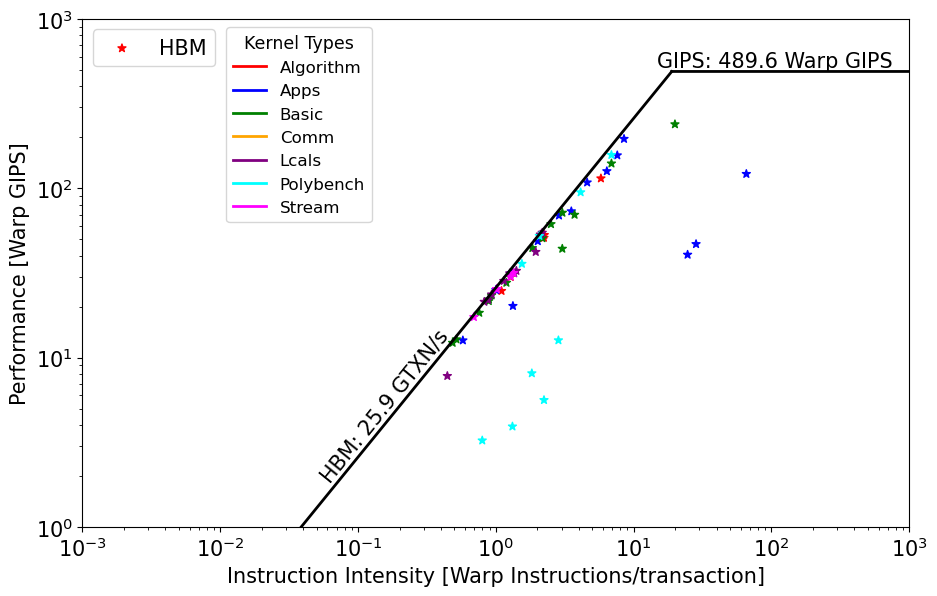

In [26]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag='HBM', data_df=agg_df)